In [6]:
! pip install langchain langchain-openai langchain-community langgraph python-dotenv faiss-cpu pypdf pdfplumber google-cloud-vision google-auth pillow



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition


In [9]:
# # usses full_text_annotation
# import os
# import io

# import pdfplumber
# from google.cloud import vision
# from google.oauth2 import service_account


# class GoogleVisionOCRProcessor:
#     def looks_like_cid_encoded(self, text: str) -> bool:
#         """Detects (cid:XX) patterns indicating CID-encoded garbage."""
#         return "(cid:" in (text or "").lower()

#     def ocr_image_bytes(self, image_bytes: bytes, client: "vision.ImageAnnotatorClient", language_hints=None) -> str:
#         """Calls Google Vision OCR on image bytes."""
#         if language_hints is None:
#             # Default: Japanese + English (can override per call)
#             language_hints = ["ja", "en"]

#         image = vision.Image(content=image_bytes)
#         image_context = vision.ImageContext(language_hints=language_hints)
#         response = client.document_text_detection(image=image, image_context=image_context)

#         if getattr(response, "error", None) and response.error.message:
#             print(f"⚠️ Google Vision OCR error: {response.error.message}")
#             return ""

#         annotation = getattr(response, "full_text_annotation", None)
#         if annotation and getattr(annotation, "text", None):
#             return annotation.text.strip()
#         return ""

#     def clamp_bbox_to_page(self, bbox, page_bbox):
#         """Ensure the bbox is safely inside the page bbox."""
#         x0, top, x1, bottom = bbox
#         page_x0, page_top, page_x1, page_bottom = page_bbox

#         x0 = max(page_x0, min(x0, page_x1))
#         x1 = max(page_x0, min(x1, page_x1))
#         top = max(page_top, min(top, page_bottom))
#         bottom = max(page_top, min(bottom, page_bottom))

#         if x0 >= x1 or top >= bottom:
#             return None
#         return (x0, top, x1, bottom)

#     def _build_vision_client(self, user_type: str) -> "vision.ImageAnnotatorClient":
#         """Create a Vision client based on user type."""
#         user_type = (user_type or "").strip().lower()

#         if user_type == "org":
#             service_account_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
#             if not service_account_path:
#                 raise ValueError(
#                     "GOOGLE_APPLICATION_CREDENTIALS is not set. Put the service account JSON path in your .env or OS env."
#                 )
#             credentials = service_account.Credentials.from_service_account_file(service_account_path)
#             print("✅ Organization user - using service account from GOOGLE_APPLICATION_CREDENTIALS")
#             return vision.ImageAnnotatorClient(credentials=credentials)

#         if user_type == "byok":
#             # Uses Application Default Credentials (gcloud auth, metadata server, etc.)
#             print("✅ BYOK user - using Application Default Credentials for Google Vision")
#             return vision.ImageAnnotatorClient()

#         raise ValueError("Invalid user_type. Use 'org' or 'byok'.")

#     def extract_text_from_pdf(self, pdf_path: str, user_type: str = "org", language_hints=None) -> str:
#         """Extract text from PDF using text layer + selective OCR, with full-page OCR fallback."""
#         client = self._build_vision_client(user_type)

#         all_pages_text = []
#         ocr_pages_count = 0

#         with pdfplumber.open(pdf_path) as pdf:
#             for i, page in enumerate(pdf.pages):
#                 print(f"\n📄 Processing Page {i + 1}/{len(pdf.pages)}")
#                 parts = []
#                 ocr_applied_this_page = False

#                 # 1) Try selectable text layer
#                 normal_text = (page.extract_text() or "").strip()
#                 if normal_text and self.looks_like_cid_encoded(normal_text):
#                     print("⚠️ Detected CID-encoded garbage in text layer. Ignoring text layer.")
#                     normal_text = ""

#                 has_text_layer = bool(normal_text)
#                 if has_text_layer:
#                     print(f"✅ Found valid text layer on page {i + 1}")
#                     parts.append("[TEXT LAYER]\n" + normal_text)

#                     # 2) OCR embedded images only (logos, stamps, scanned snippets)
#                     if page.images:
#                         print(f"🔍 Found {len(page.images)} image(s) for OCR on page {i + 1}")
#                         ocr_applied_this_page = True

#                         page_bbox = (0.0, 0.0, float(page.width), float(page.height))
#                         for img_idx, img in enumerate(page.images):
#                             try:
#                                 raw_bbox = (img["x0"], img["top"], img["x1"], img["bottom"])
#                                 safe_bbox = self.clamp_bbox_to_page(raw_bbox, page_bbox)
#                                 if not safe_bbox:
#                                     print(f"⚠️ Skipping invalid bbox: {raw_bbox}")
#                                     continue

#                                 cropped_img = page.crop(safe_bbox).to_image(resolution=500)
#                                 img_bytes = io.BytesIO()
#                                 cropped_img.save(img_bytes, format="PNG")

#                                 ocr_result = self.ocr_image_bytes(
#                                     img_bytes.getvalue(), client, language_hints=language_hints
#                                 )
#                                 if ocr_result:
#                                     parts.append("[OCR IMAGE TEXT]\n" + ocr_result)
#                             except Exception as e:
#                                 print(f"⚠️ Error OCR-ing image #{img_idx + 1} on page {i + 1}: {e}")

#                 else:
#                     # 3) If no text layer → full-page OCR
#                     print(f"⚠️ No selectable text on page {i + 1}. Performing full-page OCR.")
#                     ocr_applied_this_page = True

#                     try:
#                         page_image = page.to_image(resolution=500)
#                         img_bytes = io.BytesIO()
#                         page_image.save(img_bytes, format="PNG")

#                         full_page_ocr_result = self.ocr_image_bytes(
#                             img_bytes.getvalue(), client, language_hints=language_hints
#                         )
#                         if full_page_ocr_result:
#                             parts.append("[FULL PAGE OCR]\n" + full_page_ocr_result)
#                     except Exception as e:
#                         print(f"⚠️ Error during full-page OCR on page {i + 1}: {e}")

#                 if ocr_applied_this_page:
#                     ocr_pages_count += 1

#                 combined = "\n\n".join(parts).strip()
#                 if combined:
#                     all_pages_text.append(combined)
#                 else:
#                     print(f"⚠️ No text found at all on page {i + 1}")

#         print(f"\n📊 OCR was applied on {ocr_pages_count} out of {len(pdf.pages)} pages.")
#         print(all_pages_text)
#         out_txt = "ocr_extracted_text.txt"
#         with open(out_txt, "w", encoding="utf-8") as f:
#             for i, page_text in enumerate(all_pages_text, start=1):
#                 f.write(f"\n\n===== PAGE {i} =====\n\n")
#                 f.write(page_text)

#         print("✅ Saved to:", out_txt)
#         return "\n\n=== PAGE BREAK ===\n\n".join(all_pages_text)

In [10]:
#has all the print block removed so that it does not go into ocr_extracted_text.txt
import os
import io

import pdfplumber
from google.cloud import vision
from google.oauth2 import service_account


class GoogleVisionOCRProcessor:
    def looks_like_cid_encoded(self, text: str) -> bool:
        """Detects (cid:XX) patterns indicating CID-encoded garbage."""
        return "(cid:" in (text or "").lower()

    def ocr_image_bytes(
        self,
        image_bytes: bytes,
        client: "vision.ImageAnnotatorClient",
        language_hints=None
    ) -> str:
        """Calls Google Vision OCR on image bytes."""
        if language_hints is None:
            language_hints = ["ja", "en"]

        image = vision.Image(content=image_bytes)
        image_context = vision.ImageContext(language_hints=language_hints)
        response = client.document_text_detection(image=image, image_context=image_context)

        if getattr(response, "error", None) and response.error.message:
            print(f"⚠️ Google Vision OCR error: {response.error.message}")
            return ""

        annotation = getattr(response, "full_text_annotation", None)
        if annotation and getattr(annotation, "text", None):
            return annotation.text.strip()
        return ""

    def clamp_bbox_to_page(self, bbox, page_bbox):
        """Ensure the bbox is safely inside the page bbox."""
        x0, top, x1, bottom = bbox
        page_x0, page_top, page_x1, page_bottom = page_bbox

        x0 = max(page_x0, min(x0, page_x1))
        x1 = max(page_x0, min(x1, page_x1))
        top = max(page_top, min(top, page_bottom))
        bottom = max(page_top, min(bottom, page_bottom))

        if x0 >= x1 or top >= bottom:
            return None
        return (x0, top, x1, bottom)

    def _build_vision_client(self, user_type: str) -> "vision.ImageAnnotatorClient":
        """Create a Vision client based on user type."""
        user_type = (user_type or "").strip().lower()

        if user_type == "org":
            service_account_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
            if not service_account_path:
                raise ValueError(
                    "GOOGLE_APPLICATION_CREDENTIALS is not set. Put the service account JSON path in your .env or OS env."
                )
            credentials = service_account.Credentials.from_service_account_file(service_account_path)
            print("✅ Organization user - using service account from GOOGLE_APPLICATION_CREDENTIALS")
            return vision.ImageAnnotatorClient(credentials=credentials)

        if user_type == "byok":
            print("✅ BYOK user - using Application Default Credentials for Google Vision")
            return vision.ImageAnnotatorClient()

        raise ValueError("Invalid user_type. Use 'org' or 'byok'.")

    def extract_text_from_pdf(
        self,
        pdf_path: str,
        user_type: str = "org",
        language_hints=None,
        out_txt: str = "ocr_extracted_text_new.txt",
        keep_page_breaks: bool = True
    ) -> str:
        """
        Extract text from PDF using text layer + selective OCR, with full-page OCR fallback.

        IMPORTANT:
        - Saves ONLY the extracted text (no '[FULL PAGE OCR]' / '[TEXT LAYER]' / page headers).
        """
        client = self._build_vision_client(user_type)

        all_pages_text = []
        ocr_pages_count = 0

        with pdfplumber.open(pdf_path) as pdf:
            for i, page in enumerate(pdf.pages):
                print(f"\n📄 Processing Page {i + 1}/{len(pdf.pages)}")
                parts = []
                ocr_applied_this_page = False

                # 1) Try selectable text layer
                normal_text = (page.extract_text() or "").strip()
                if normal_text and self.looks_like_cid_encoded(normal_text):
                    print("⚠️ Detected CID-encoded garbage in text layer. Ignoring text layer.")
                    normal_text = ""

                has_text_layer = bool(normal_text)

                if has_text_layer:
                    print(f"✅ Found valid text layer on page {i + 1}")
                    parts.append(normal_text)  # ✅ no label

                    # 2) OCR embedded images only (logos, stamps, scanned snippets)
                    if page.images:
                        print(f"🔍 Found {len(page.images)} image(s) for OCR on page {i + 1}")
                        ocr_applied_this_page = True

                        page_bbox = (0.0, 0.0, float(page.width), float(page.height))
                        for img_idx, img in enumerate(page.images):
                            try:
                                raw_bbox = (img["x0"], img["top"], img["x1"], img["bottom"])
                                safe_bbox = self.clamp_bbox_to_page(raw_bbox, page_bbox)
                                if not safe_bbox:
                                    print(f"⚠️ Skipping invalid bbox: {raw_bbox}")
                                    continue

                                cropped_img = page.crop(safe_bbox).to_image(resolution=500)
                                img_bytes = io.BytesIO()
                                cropped_img.save(img_bytes, format="PNG")

                                ocr_result = self.ocr_image_bytes(
                                    img_bytes.getvalue(), client, language_hints=language_hints
                                ).strip()

                                if ocr_result:
                                    parts.append(ocr_result)  # ✅ no label
                            except Exception as e:
                                print(f"⚠️ Error OCR-ing image #{img_idx + 1} on page {i + 1}: {e}")

                else:
                    # 3) If no text layer → full-page OCR
                    print(f"⚠️ No selectable text on page {i + 1}. Performing full-page OCR.")
                    ocr_applied_this_page = True

                    try:
                        page_image = page.to_image(resolution=500)
                        img_bytes = io.BytesIO()
                        page_image.save(img_bytes, format="PNG")

                        full_page_ocr_result = self.ocr_image_bytes(
                            img_bytes.getvalue(), client, language_hints=language_hints
                        ).strip()

                        if full_page_ocr_result:
                            parts.append(full_page_ocr_result)  # ✅ no label
                    except Exception as e:
                        print(f"⚠️ Error during full-page OCR on page {i + 1}: {e}")

                if ocr_applied_this_page:
                    ocr_pages_count += 1

                combined = "\n\n".join([p for p in parts if p]).strip()
                if combined:
                    all_pages_text.append(combined)
                else:
                    print(f"⚠️ No text found at all on page {i + 1}")

        print(f"\n📊 OCR was applied on {ocr_pages_count} out of {len(pdf.pages)} pages.")

        # ✅ Save ONLY text (no PAGE headers, no OCR labels)
        final_text = ("".join(all_pages_text)) if keep_page_breaks else ("\n\n".join(all_pages_text))
        with open(out_txt, "w", encoding="utf-8") as f:
            f.write(final_text)

        print("✅ Saved to:", out_txt)
        return final_text


In [11]:
# import os
# import io
# import re
# import unicodedata

# import pdfplumber
# from google.cloud import vision
# from google.oauth2 import service_account


# class GoogleVisionOCRProcessor:
#     def looks_like_cid_encoded(self, text: str) -> bool:
#         return "(cid:" in (text or "").lower()

#     # ------------------- CLEANING -------------------
#     def _alnum_ratio(self, s: str) -> float:
#         s = s or ""
#         if not s:
#             return 0.0
#         alnum = sum(ch.isalnum() for ch in s)
#         return alnum / max(1, len(s))

#     def _is_repeated_garbage(self, s: str) -> bool:
#         # ggg, !!!, --- etc.
#         s = (s or "").strip()
#         return bool(re.fullmatch(r"(.)\1{2,}", s)) and len(s) <= 6

#     def _is_noise_line(self, line: str) -> bool:
#         l = (line or "").strip()
#         if not l:
#             return True

#         # common OCR noise from icons
#         if l in {"x", "X", "ggg", "GGG"}:
#             return True

#         # repeated single char noise
#         if self._is_repeated_garbage(l):
#             return True

#         # mostly symbols and very short
#         if len(l) <= 3 and self._alnum_ratio(l) == 0:
#             return True

#         # low alnum ratio (icons / decoration) and short
#         if self._alnum_ratio(l) < 0.20 and len(l) < 20:
#             return True

#         return False

#     def _strip_weird_edge_symbols(self, line: str) -> str:
#         # remove weird trailing symbols like 《 or random OCR artifacts
#         line = (line or "").strip()
#         line = re.sub(r"[^\w\)\]\}\.,:;!?%$@#'\"/\\\-+& ]+$", "", line)
#         return line.strip()

#     def _should_join(self, prev_line: str, next_line: str) -> bool:
#         prev_line = (prev_line or "").rstrip()
#         next_line = (next_line or "").lstrip()
#         if not prev_line or not next_line:
#             return False

#         # If next starts lowercase => wrapped line
#         if next_line[0].islower():
#             return True

#         # If next starts with digit => "tools address" + "5 key..." etc.
#         if next_line[0].isdigit():
#             return True

#         # If next begins with connectors like AND/OR/& => join
#         if re.match(r"^(and|or|&)\b", next_line, flags=re.IGNORECASE):
#             return True

#         # If prev ends with common join-words
#         if re.search(r"\b(and|or|with|of|to|for|in|on|at|by)\s*$", prev_line, flags=re.IGNORECASE):
#             return True

#         # If prev ends with hyphen
#         if prev_line.endswith(("-", "–")):
#             return True

#         # If next is a single word, likely continuation (e.g., "collaboration")
#         if len(next_line.split()) == 1 and len(prev_line) < 60:
#             # avoid joining brand word lines like "Cognixia"
#             if next_line.strip().lower() in {"cognixia"}:
#                 return False
#             return True

#         return False

#     def clean_ocr_text(self, text: str) -> str:
#         """
#         Cleans OCR output:
#         - normalizes unicode
#         - removes noise lines (ggg, X, symbol-only)
#         - joins wrapped lines
#         """
#         text = unicodedata.normalize("NFKC", text or "")
#         text = text.replace("\x00", " ")
#         text = "".join(ch for ch in text if ch.isprintable())

#         raw_lines = [ln.strip() for ln in text.splitlines()]
#         lines = []
#         for ln in raw_lines:
#             ln = self._strip_weird_edge_symbols(ln)
#             if self._is_noise_line(ln):
#                 continue
#             if ln:
#                 lines.append(ln)

#         merged = []
#         buf = ""
#         for ln in lines:
#             if not buf:
#                 buf = ln
#                 continue

#             if self._should_join(buf, ln):
#                 buf = f"{buf} {ln}"
#             else:
#                 merged.append(buf.strip())
#                 buf = ln

#         if buf:
#             merged.append(buf.strip())

#         # remove excessive blank lines (we removed most already)
#         out = "\n".join(merged)
#         out = re.sub(r"\n{3,}", "\n\n", out).strip()
#         return out

#     # ------------------- OCR -------------------
#     def ocr_image_bytes(self, image_bytes: bytes, client: "vision.ImageAnnotatorClient", language_hints=None) -> str:
#         if language_hints is None:
#             language_hints = ["en"]

#         image = vision.Image(content=image_bytes)
#         image_context = vision.ImageContext(language_hints=language_hints)
#         response = client.document_text_detection(image=image, image_context=image_context)

#         if getattr(response, "error", None) and response.error.message:
#             print(f"⚠️ Google Vision OCR error: {response.error.message}")
#             return ""

#         annotation = getattr(response, "full_text_annotation", None)
#         if annotation and getattr(annotation, "text", None):
#             return annotation.text.strip()
#         return ""

#     def clamp_bbox_to_page(self, bbox, page_bbox):
#         x0, top, x1, bottom = bbox
#         page_x0, page_top, page_x1, page_bottom = page_bbox

#         x0 = max(page_x0, min(x0, page_x1))
#         x1 = max(page_x0, min(x1, page_x1))
#         top = max(page_top, min(top, page_bottom))
#         bottom = max(page_top, min(bottom, page_bottom))

#         if x0 >= x1 or top >= bottom:
#             return None
#         return (x0, top, x1, bottom)

#     def _build_vision_client(self, user_type: str) -> "vision.ImageAnnotatorClient":
#         user_type = (user_type or "").strip().lower()

#         if user_type == "org":
#             service_account_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
#             if not service_account_path:
#                 raise ValueError("GOOGLE_APPLICATION_CREDENTIALS is not set.")
#             credentials = service_account.Credentials.from_service_account_file(service_account_path)
#             print("✅ Organization user - using service account from GOOGLE_APPLICATION_CREDENTIALS")
#             return vision.ImageAnnotatorClient(credentials=credentials)

#         if user_type == "byok":
#             print("✅ BYOK user - using Application Default Credentials for Google Vision")
#             return vision.ImageAnnotatorClient()

#         raise ValueError("Invalid user_type. Use 'org' or 'byok'.")

#     # ------------------- PDF EXTRACT + SAVE -------------------
#     def extract_text_from_pdf(
#         self,
#         pdf_path: str,
#         user_type: str = "org",
#         language_hints=None,
#         out_txt: str = "ocr_extracted_text.txt",
#         keep_page_breaks: bool = True
#     ) -> str:
#         client = self._build_vision_client(user_type)

#         all_pages_text = []
#         ocr_pages_count = 0

#         with pdfplumber.open(pdf_path) as pdf:
#             for i, page in enumerate(pdf.pages):
#                 print(f"\n📄 Processing Page {i + 1}/{len(pdf.pages)}")
#                 parts = []
#                 ocr_applied_this_page = False

#                 # 1) Try selectable text layer
#                 normal_text = (page.extract_text() or "").strip()
#                 if normal_text and self.looks_like_cid_encoded(normal_text):
#                     print("⚠️ Detected CID-encoded garbage in text layer. Ignoring text layer.")
#                     normal_text = ""

#                 if normal_text:
#                     # clean text layer too
#                     normal_text = self.clean_ocr_text(normal_text)
#                     if normal_text:
#                         parts.append(normal_text)

#                     # OCR embedded images if any
#                     if page.images:
#                         ocr_applied_this_page = True
#                         page_bbox = (0.0, 0.0, float(page.width), float(page.height))
#                         for img in page.images:
#                             try:
#                                 raw_bbox = (img["x0"], img["top"], img["x1"], img["bottom"])
#                                 safe_bbox = self.clamp_bbox_to_page(raw_bbox, page_bbox)
#                                 if not safe_bbox:
#                                     continue

#                                 cropped_img = page.crop(safe_bbox).to_image(resolution=500)
#                                 img_bytes = io.BytesIO()
#                                 cropped_img.save(img_bytes, format="PNG")

#                                 ocr_result = self.ocr_image_bytes(img_bytes.getvalue(), client, language_hints=language_hints)
#                                 ocr_result = self.clean_ocr_text(ocr_result)

#                                 if ocr_result:
#                                     parts.append(ocr_result)
#                             except Exception as e:
#                                 print(f"⚠️ Error OCR-ing embedded image on page {i + 1}: {e}")

#                 else:
#                     # 2) Full-page OCR
#                     print(f"⚠️ No selectable text on page {i + 1}. Performing full-page OCR.")
#                     ocr_applied_this_page = True

#                     try:
#                         page_image = page.to_image(resolution=500)
#                         img_bytes = io.BytesIO()
#                         page_image.save(img_bytes, format="PNG")

#                         ocr_text = self.ocr_image_bytes(img_bytes.getvalue(), client, language_hints=language_hints)
#                         ocr_text = self.clean_ocr_text(ocr_text)

#                         if ocr_text:
#                             parts.append(ocr_text)
#                     except Exception as e:
#                         print(f"⚠️ Error during full-page OCR on page {i + 1}: {e}")

#                 if ocr_applied_this_page:
#                     ocr_pages_count += 1

#                 page_text = "\n\n".join([p for p in parts if p]).strip()
#                 if page_text:
#                     all_pages_text.append(page_text)
#                 else:
#                     print(f"⚠️ No text found at all on page {i + 1}")

#         print(f"\n📊 OCR was applied on {ocr_pages_count} out of {len(pdf.pages)} pages.")

#         final_text = ("\n\n=== PAGE BREAK ===\n\n".join(all_pages_text)) if keep_page_breaks else ("\n\n".join(all_pages_text))

#         with open(out_txt, "w", encoding="utf-8") as f:
#             f.write(final_text)

#         print("✅ Saved to:", out_txt)
#         return final_text


# # ------------------- Example usage -------------------
# # ocr = GoogleVisionOCRProcessor()
# # text = ocr.extract_text_from_pdf(
# #     "/mnt/data/1-Cognixia-SecOps.pdf",
# #     user_type="org",
# #     language_hints=["en"],
# #     out_txt="secops_clean.txt",
# #     keep_page_breaks=True
# # )


In [12]:
#load_dotenv()

In [13]:
llm = ChatOpenAI(model='gpt-4o')

In [14]:
try:
    from langchain_core.documents import Document
except ImportError:
    # Older LangChain versions
    from langchain.docstore.document import Document

PDF_PATH = "1-Cognixia-SecOps.pdf"
USER_TYPE = "org"  # 'org' (service account JSON in GOOGLE_APPLICATION_CREDENTIALS) or 'byok' (ADC)

ocr = GoogleVisionOCRProcessor()

try:
    extracted_text = ocr.extract_text_from_pdf(PDF_PATH, user_type=USER_TYPE)

    pages = [p.strip() for p in extracted_text.split("\n\n=== PAGE BREAK ===\n\n") if p.strip()]
    docs = [
        Document(page_content=p, metadata={"source": PDF_PATH, "page": i + 1})
        for i, p in enumerate(pages)
    ]
    print(f"✅ Loaded {len(docs)} page(s) using pdfplumber + Google Vision OCR")

except Exception as e:
    print(f"⚠️ OCR pipeline failed ({e}). Falling back to PyPDFLoader text extraction.")
    loader = PyPDFLoader(PDF_PATH)
    docs = loader.load()


✅ Organization user - using service account from GOOGLE_APPLICATION_CREDENTIALS

📄 Processing Page 1/2
⚠️ No selectable text on page 1. Performing full-page OCR.

📄 Processing Page 2/2
⚠️ No selectable text on page 2. Performing full-page OCR.

📊 OCR was applied on 2 out of 2 pages.
✅ Saved to: ocr_extracted_text_new.txt
✅ Loaded 1 page(s) using pdfplumber + Google Vision OCR


In [15]:
len(docs)

1

In [16]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [17]:
len(chunks)

1

In [18]:
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')
vector_store = FAISS.from_documents(chunks, embeddings)

In [19]:
vector_store

In [20]:
# retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})
retriever = vector_store.as_retriever(search_kwargs={"k": 10})


In [21]:
# ✅ Sanity-check: did we actually load and chunk the PDF?
import os
print('CWD:', os.getcwd())
print('PDF_PATH:', PDF_PATH)
print('PDF exists:', os.path.exists(PDF_PATH))
print('docs:', len(docs))
print('chunks:', len(chunks))
if chunks:
    print('\n--- SAMPLE CHUNK (first 600 chars) ---')
    print(chunks[0].page_content)


CWD: /Users/vishruth/Desktop/work/brandlove_poc
PDF_PATH: 1-Cognixia-SecOps.pdf
PDF exists: True
docs: 1
chunks: 1

--- SAMPLE CHUNK (first 600 chars) ---
Cognixia
Why Organizations
Should Implement
SecOps?
Goals And Benefits
Strengthened security expertise
Regulatory compliance
Enhanced communication and
collaboration
Improved business reputation
Continuous protection with proactive
threat prevention
Quick and effective incident response
Reduced breach costs
Enhanced resilience and credibility《
Cognixia
Essential SecOps tools address
5 key threat areas:
DNS SECURITY
ggg
DATA
DISCOVERY
NETWORK DETECTION
ANTI-PHISHING
AND RESPONSE
X
PACKET-LEVEL
VISIBILITY


In [22]:
# # ✅ Deterministic RAG (always retrieves from the PDF before answering)
# RESUME_SYSTEM = """You are a strict resume evaluator.
# You MUST answer using ONLY the provided resume context (retrieved from the PDF).
# If the context does NOT contain the needed info, say clearly: 'Not found in the PDF.'

# When asked about candidate fit for a Generative AI / LLM role or internship, provide:
# 1) Resume summary (2-4 bullets)
# 2) Relevant GenAI/ML strengths
# 3) Gaps / risks
# 4) Fit score (0-10) with 1-line justification
# 5) Next steps / interview questions
# """

# def resume_answer(query: str) -> str:
#     hits = retriever.invoke(query)
#     if not hits:
#         return (
#             "I couldn't retrieve any relevant text from the PDF for this question. "
#             "Check that docs/chunks are not empty and that OCR/text extraction worked."
#         )

#     context = "\n\n".join(
#         [f"[Page {d.metadata.get('page','?')}]\n{d.page_content}" for d in hits]
#     )

#     messages = [
#         SystemMessage(content=RESUME_SYSTEM),
#         HumanMessage(content=f"Question: {query}\n\nResume context from PDF:\n{context}")
#     ]
#     return llm.invoke(messages).content

# print(resume_answer('Based on the resume, is the candidate suitable for a Generative AI internship? Give reasoning and a score out of 10.'))


In [23]:
PDF_ANALYST_SYSTEM = """You are a strict PDF analyst.

RULES (NON-NEGOTIABLE):
- You MUST answer using ONLY the provided PDF context (retrieved text).
- If a requested FACT is not present in the context, say exactly: 'Not found in the PDF.'
- Do NOT use outside knowledge.

IMPORTANT OUTPUT RULES:
- Sections 1–3 must be extracted strictly from the PDF context.
- Section 4 must be derived from the PDF context (actionable takeaways).
- Section 5 (questions) must be GENERATED based on topics found in the PDF context.
  - Never say 'Not found in the PDF.' for section 5 unless the PDF context is empty.

When the user asks to analyze the PDF, respond in this structure:
1) High-level summary (3-6 bullets)
2) Key topics / modules (bullets)
3) Important terms / definitions (only if explicitly defined; otherwise say 'Not found in the PDF.')
4) Practical takeaways / action items (derived from context)
5) Likely questions for assessment/interview (8-12 questions based on context)
"""


In [24]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [25]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [26]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [27]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [28]:
tool_node = ToolNode(tools)

In [29]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

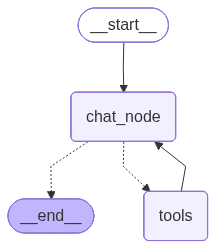

In [30]:
chatbot

In [31]:
# # (Optional) LangGraph tool-calling demo (kept for reference)
# # Tip: Use resume_answer() above for guaranteed retrieval.
# result = chatbot.invoke(
#     {
#         "messages": [
#             SystemMessage(content=(
#                 "You are evaluating the candidate using the PDF resume. "
#                 "ALWAYS call rag_tool to fetch resume context before answering. "
#                 "If info isn't in the PDF, say 'Not found in the PDF.'"
#             )),
#             HumanMessage(content=(
#                 "Based on the resume in the PDF, is the candidate suitable for a Generative AI internship? "
#                 "Give strengths, gaps, fit score out of 10, and 5 interview questions."
#             ))
#         ]
#     }
# )


In [32]:
# (Optional) LangGraph tool-calling demo (kept for reference)
result = chatbot.invoke(
    {
        "messages": [
            SystemMessage(content=(
                "You are a strict PDF analyst.\n"
                "MANDATORY: Before writing ANY answer, you MUST call rag_tool using the user's request as input.\n"
                "Then answer using ONLY the rag_tool output (no outside knowledge).\n"
                "If rag_tool output is empty or does not contain relevant text, say exactly: 'Not found in the PDF.'\n\n"

                "OUTPUT RULES:\n"
                "- Sections 1–5 must be extracted/derived ONLY from rag_tool output.\n"
                "- Section 3 (tools/technologies): list ONLY explicitly named tools. "
                "If none are named, say: 'No specific tool names are mentioned in the retrieved PDF context.'\n"
                "- Section 4 (definitions): list ONLY explicitly defined terms; otherwise say: 'Not found in the PDF.'\n"
                "- Section 6 (assessment questions): ALWAYS generate 10 questions based on topics found in rag_tool output. "
                "Never say 'Not found in the PDF.' for section 6 unless rag_tool output is empty.\n\n"

                "Return the answer in the exact numbered structure requested."
            )),
            HumanMessage(content=(
                "Analyze this PDF and provide:\n"
                "1) High-level summary (3-6 bullets)\n"
                "2) Key topics/modules\n"
                "3) Tools/technologies mentioned\n"
                "4) Important terms/definitions (if present)\n"
                "5) Practical takeaways/action items\n"
                "6) prompt to recreate the document"
            ))
        ]
    }
)

# print(result["messages"][-1].content)


In [33]:
print(result['messages'][-1].content)

1) High-level summary:
   - The document discusses the importance of implementing SecOps in organizations.
   - Goals and benefits include strengthened security expertise, regulatory compliance, and improved business reputation.
   - It emphasizes proactive threat prevention and quick incident response.
   - Continuous protection and reduced breach costs are highlighted.
   - Enhanced resilience and credibility are also mentioned as key outcomes.

2) Key topics/modules:
   - Importance of SecOps
   - Goals and benefits of SecOps implementation
   - Threat areas addressed by essential SecOps tools

3) Tools/technologies mentioned:
   - DNS security
   - Data discovery
   - Network detection and response
   - Anti-phishing
   - Packet-level visibility

4) Important terms/definitions:
   - Not found in the PDF.

5) Practical takeaways/action items:
   - Organizations should implement SecOps to enhance security expertise and regulatory compliance.
   - Focus on proactive threat prevention 